In [1]:
import torch
# GPU varsa kullan, yoksa CPU kullan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılacak cihaz:", device)

Kullanılacak cihaz: cuda


In [2]:
# --- Gerekli kütüphaneler ---
import torch
from torchvision import datasets, transforms
import torch
print("GPU kullanılabilir mi?", torch.cuda.is_available())
print("Kullanılan cihaz:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# --- Transform: Yeniden boyutlandırma + tensor + normalizasyon ---
transform = transforms.Compose([
 transforms.Resize((224,224)), # Tüm görüntüleri 224x224 boyutuna getir
 transforms.ToTensor(), # PyTorch tensor'ına çevir
 transforms.Normalize([0.485,0.456,0.406], # ImageNet normalizasyonu (mean)
 [0.229,0.224,0.225]) # ImageNet normalizasyonu (std)
])

# --- Dataset klasör yolu ---
DATA_DIR = r'C:\Users\Külkedisi\Desktop\DLP Batch\garbage-dataset'
# --- Dataset oluştur ---
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
print("Toplam örnek sayısı:", len(dataset))
print("Sınıflar:", dataset.classes)


GPU kullanılabilir mi? True
Kullanılan cihaz: NVIDIA GeForce RTX 4060 Laptop GPU
Toplam örnek sayısı: 19762
Sınıflar: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


mkdir -p failed for path C:\Users\Külkedisi\.matplotlib: [WinError 5] Access is denied: 'C:\\Users\\Külkedisi\\.matplotlib'
Matplotlib created a temporary cache directory at C:\Users\KLKEDI~1\AppData\Local\Temp\matplotlib-01idiqln because there was an issue with the default path (C:\Users\Külkedisi\.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Kullanılan cihaz: cuda
Sınıf sayısı: 10

--- LR TEST: 0.000010 ---
Epoch 1/5 - Train Acc: 0.5640 - Val Acc: 0.6076
Epoch 2/5 - Train Acc: 0.6978 - Val Acc: 0.6600
Epoch 3/5 - Train Acc: 0.7790 - Val Acc: 0.7101
Epoch 4/5 - Train Acc: 0.8334 - Val Acc: 0.7043
Epoch 5/5 - Train Acc: 0.8772 - Val Acc: 0.7187

--- LR TEST: 0.000056 ---
Epoch 1/5 - Train Acc: 0.5525 - Val Acc: 0.5656
Epoch 2/5 - Train Acc: 0.6900 - Val Acc: 0.6909
Epoch 3/5 - Train Acc: 0.7715 - Val Acc: 0.7402
Epoch 4/5 - Train Acc: 0.8270 - Val Acc: 0.6653
Epoch 5/5 - Train Acc: 0.8560 - Val Acc: 0.7516

--- LR TEST: 0.000316 ---
Epoch 1/5 - Train Acc: 0.4708 - Val Acc: 0.5742
Epoch 2/5 - Train Acc: 0.5883 - Val Acc: 0.5586
Epoch 3/5 - Train Acc: 0.6434 - Val Acc: 0.6259
Epoch 4/5 - Train Acc: 0.6915 - Val Acc: 0.6284
Epoch 5/5 - Train Acc: 0.7276 - Val Acc: 0.6985

--- LR TEST: 0.001778 ---
Epoch 1/5 - Train Acc: 0.3133 - Val Acc: 0.3941
Epoch 2/5 - Train Acc: 0.3945 - Val Acc: 0.4270
Epoch 3/5 - Train Acc: 0.4422 - Val 

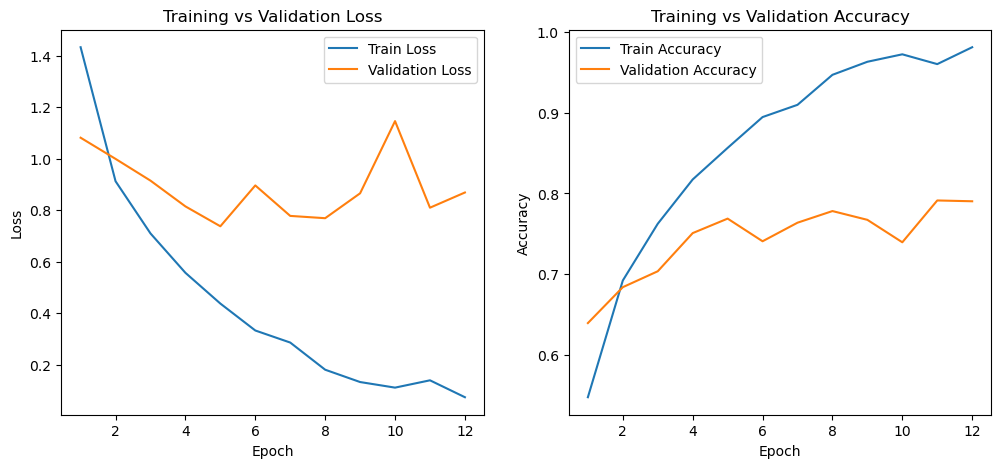


📌 Accuracy: 0.7902858588413862
📌 Macro F1: 0.7380027132496385

📌 Classification Report:
              precision    recall  f1-score   support

     battery       0.60      0.77      0.67       189
  biological       0.75      0.68      0.71       199
   cardboard       0.78      0.85      0.82       365
     clothes       0.88      0.95      0.91      1066
       glass       0.78      0.79      0.78       612
       metal       0.74      0.41      0.53       204
       paper       0.81      0.78      0.79       336
     plastic       0.71      0.79      0.75       397
       shoes       0.75      0.68      0.71       396
       trash       0.83      0.61      0.70       189

    accuracy                           0.79      3953
   macro avg       0.76      0.73      0.74      3953
weighted avg       0.79      0.79      0.79      3953



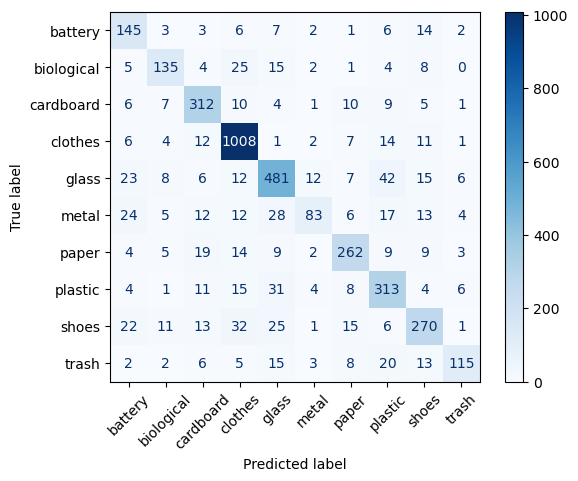

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os

# ============================================
# 1️⃣ CİHAZ SEÇİMİ
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# ============================================
# 2️⃣ GÖRÜNTÜ İŞLEME
# ============================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dataset yolu BURADA GÜNCELLENDİ
DATA_DIR = r'C:\Users\Külkedisi\Desktop\DLP Batch\garbage-dataset'

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
targets = [s[1] for s in dataset.samples]

# ============================================
# 3️⃣ STRATIFIED TRAIN/VAL SPLIT
# ============================================
train_idx, val_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    shuffle=True,
    stratify=targets,
    random_state=42
)

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

print("Sınıf sayısı:", len(dataset.classes))
num_classes = len(dataset.classes)

# ============================================
# 4️⃣ 6 KATMANLI CNN + BATCHNORM (Dropout Yok)
# ============================================
class CNN6(nn.Module):
    def __init__(self, num_classes):
        super(CNN6, self).__init__()
        
        self.features = nn.Sequential(
            # 1. blok
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # 2. blok
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # 3. blok
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # 4. blok
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # 5. blok
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # 6. blok
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = CNN6(num_classes).to(device)

# ============================================
# 5️⃣ EĞİTİM FONKSİYONU (EARLY STOPPING DAHİL)
# ============================================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=5):

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    
    best_val_loss = float("inf")
    patience_count = 0

    for epoch in range(epochs):
        
        model.train()
        train_loss, correct, total = 0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, pred = outputs.max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss /= len(train_loader)

        # VALIDASYON
        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, pred = outputs.max(1)
                correct += pred.eq(labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_loss /= len(val_loader)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

        # EARLY STOPPING
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_count = 0
            best_model_state = model.state_dict()
        else:
            patience_count += 1
            if patience_count >= patience:
                print("⛔ Erken durdurma tetiklendi!")
                break

    model.load_state_dict(best_model_state)
    return model, history

# ============================================
# 6️⃣ RANDOM LR SEARCH
# ============================================
def random_lr_search(model, train_loader, val_loader):

    learning_rates = np.logspace(-5, -2, 5)
    criterion = nn.CrossEntropyLoss()

    best_lr = None
    best_acc = 0

    for lr in learning_rates:
        temp_model = CNN6(num_classes).to(device)
        optimizer = optim.Adam(temp_model.parameters(), lr=lr)

        print(f"\n--- LR TEST: {lr:.6f} ---")
        temp_model, hist = train_model(temp_model, train_loader, val_loader, criterion, optimizer, epochs=5, patience=5)

        val_accuracy = hist["val_acc"][-1]

        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_lr = lr

    print(f"\n🔍 En iyi LR: {best_lr:.6f}")
    return best_lr

best_lr = random_lr_search(model, train_loader, val_loader)

# ============================================
# 7️⃣ FİNAL EĞİTİM
# ============================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

model, history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=7)

# ============================================
# 8️⃣ EĞİTİM GRAFİĞİ
# ============================================
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss grafiği
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

plot_training_history(history)

# ============================================
# 9️⃣ MODEL DEĞERLENDİRME
# ============================================
def evaluate_model(model, val_loader):

    model.eval()
    preds, true = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)

            _, predicted = outputs.max(1)
            preds.extend(predicted.cpu().numpy())
            true.extend(labels.numpy())

    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average="macro")

    print("\n📌 Accuracy:", acc)
    print("📌 Macro F1:", f1)
    print("\n📌 Classification Report:")
    print(classification_report(true, preds, target_names=dataset.classes))

    # Confusion Matrix
    cm = confusion_matrix(true, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=dataset.classes)
    disp.plot(xticks_rotation=45, cmap="Blues")
    plt.show()

evaluate_model(model, val_loader)